# Rosenbrock function: Bound constrained optimization
First order active set bound-constrained nonlinear programming

2d Rosenbrock example: This notebook illustrates the usage of FOAS to solve the bound-constrained 2d Rosenbrock function. It produces a plot showing the steps taken by the solver to find the solution point.

In [1]:
from naginterfaces.base import utils
from naginterfaces.library import opt

Add objective function, gradient and monitoring callback

In [2]:
objfun = lambda x, inform: ((1. - x[0])**2 + 100.*(x[1] - x[0]**2)**2, inform)

def objgrd(x, fdx, inform):
    """The objective's gradient."""
    fdx[:] = [
        2.*x[0] - 400.*x[0]*(x[1]-x[0]**2) - 2.,
        200.*(x[1]-x[0]**2),
    ]
    return inform


steps = []
def monit(x, rinfo, _stats, _data=None):
    """The monitor function."""
    steps.append([x[0], x[1], rinfo[0]])


Specify initial guess

In [3]:
x = [-1., -1.5]

Define the nonlinear objective (add to handle)

In [4]:
nvar = len(x)
handle = opt.handle_init(nvar)
opt.handle_set_nlnobj(handle, idxfd=list(range(1, nvar+1)))

Add the box bounds on the variable x to the handle

In [5]:
bl = [-1., -2.]
bu = [0.8, 2.]
opt.handle_set_simplebounds(
    handle,
    bl=bl,
    bu=bu,
)

Set some algorithmic options

In [6]:
for option in [
    'FOAS Print Frequency = 1',
    'Print Solution = yes',
    'FOAS Monitor Frequency = 1',
    'Print Level = 2',
    'Monitoring Level = 1',
]:
    opt.handle_opt_set(handle, option)

Use an explicit I/O manager for abbreviated iteration output

In [7]:
iom = utils.FileObjManager(locus_in_output=False)

Solve the problem

In [8]:
ret = opt.handle_solve_bounds_foas(handle, x, objfun=objfun, objgrd=objgrd, monit=monit, io_manager=iom)
steps.append([ret.x[0], ret.x[1], ret.rinfo[0]]) # Add last step


 ----------------------------------------------------------
  E04KF, First order method for bound-constrained problems
 ----------------------------------------------------------

 Begin of Options
     Print File                    =                   9     * d
     Print Level                   =                   2     * U
     Print Options                 =                 Yes     * d
     Print Solution                =                 All     * U
     Monitoring File               =                  -1     * d
     Monitoring Level              =                   1     * U
     Foas Monitor Frequency        =                   1     * U
     Foas Print Frequency          =                   1     * U

     Infinite Bound Size           =         1.00000E+20     * d
     Task                          =            Minimize     * d
     Stats Time                    =                  No     * d
     Time Limit                    =         1.00000E+06     * d
     Verify Derivati

Retrieve Lagrange multipliers

In [9]:
import numpy as np
from naginterfaces.base.opt import handle_set_get_real
mult = np.empty(2*nvar)
mult.fill(0.)
ret = handle_set_get_real(handle, "Dual Variables", 1, 2*nvar, mult)
print("Lagrange multipliers: ", mult[0:-1:2]-mult[1:ret+1:2])

Lagrange multipliers:  [-0.4  0. ]


Destroy the handle

In [10]:
opt.handle_free(handle)

Evaluate the funtion over the domain

In [11]:
x_m = np.linspace(bl[0]-0.5, bu[0]+0.5, 101)
y_m = np.linspace(bl[1]-0.5, bu[1]+0.5, 101)
z_m = np.empty((101, 101))
j = y_m[0]
for i in range(0, 101):
    for j in range(0, 101):
        z_m[i, j], _inform = objfun([x_m[i], y_m[j]], 1)
nb = 25
x_box = np.linspace(bl[0], bu[0], nb)
y_box = np.linspace(bl[1], bu[1], nb)
box = np.array([np.concatenate([x_box, bu[0]*np.ones(nb), x_box[::-1], bl[0]*np.ones(nb)]),
      np.concatenate([bl[1]*np.ones(nb), y_box, bu[1]*np.ones(nb), y_box[::-1]])])
z_box = np.empty(box[0].shape)
for i in range(0, (box[0].size)):
    z_box[i], _inform = objfun([box[0][i], box[1][i]], 1)

X, Y = np.meshgrid(x_m, y_m, indexing='ij')

Plot function and steps taken

In [12]:
# Jupyter magic for displaying figures inline:
%matplotlib inline
steps = np.column_stack(steps)

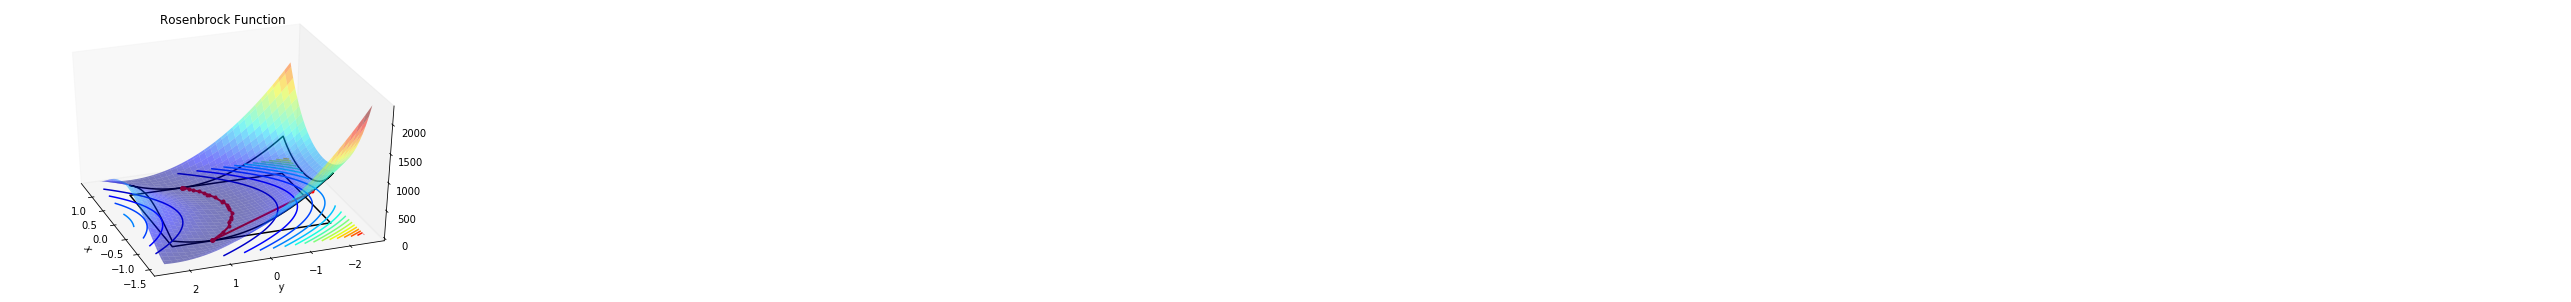

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = Axes3D(fig)
ax = fig.gca(projection='3d')
ax.grid(False)
ax.plot(box[0], box[1], z_box, 'k-', linewidth=1.5)
ax.plot([bl[0], bu[0], bu[0], bl[0], bl[0]], [bl[1], bl[1], bu[1], bu[1], bl[1]], -1.2*np.ones(5), 'k-')
ax.contour(X, Y, z_m, 15, offset=-1.2, cmap=cm.jet)
ax.plot_surface(X, Y, z_m, cmap=cm.jet, alpha=0.5)
ax.set_title('Rosenbrock Function')
ax.set_xlabel(r'$\mathit{x}$')
ax.set_ylabel(r'$\mathit{y}$')
ax.plot(steps[0], steps[1], steps[2], 'o-', color='red', markersize=3, linewidth=2)
ax.azim = 160
ax.elev = 35
plt.show()